## 获取EAR和PuilSize以及Emotion标签
- 使用dlib，模型为shape_predictor_68_face_landmarks.dat，一个眼睛关键点检测模型，一共68个关键点，左眼可以访问（36，42），右眼可以访问（42，48）
- EAR计算公式：EAR = (||p2-p6|| + ||p3-p5||) / (2 * ||p1-p4||)
- 瞳孔大小计算： 通过二值化图像，计算黑色像素比例来估计瞳孔大小

In [4]:
import os
import cv2
import dlib
import pandas as pd
import numpy as np

# 初始化dlib的关键点检测器和预训练模型
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 眼睛关键点索引
LEFT_EYE_POINTS = list(range(36, 42))
RIGHT_EYE_POINTS = list(range(42, 48))

def filter_out_of_bounds(points, image_shape):
    """
    过滤超出图片范围的点
    :param points: 检测的关键点列表，形状为 (N, 2)
    :param image_shape: 图片的形状 (height, width)
    :return: 过滤后的点列表
    """
    height, width = image_shape[:2]
    filtered_points = [point for point in points if 0 <= point[0] < width and 0 <= point[1] < height]
    return np.array(filtered_points)

def calculate_ear(eye_points):
    # 计算眼睛纵横比 (EAR)
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    ear = (A + B) / (2.0 * C)
    return ear

def calculate_pupil_size(eye_image):
    # 计算瞳孔大小（以黑色区域占比估算
    gray = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
    black_pixels = cv2.countNonZero(threshold)
    total_pixels = eye_image.shape[0] * eye_image.shape[1]
    pupil_size = black_pixels / total_pixels
    return pupil_size

def process_image(image_path):
    # 对单张图片处理，返回EAR和瞳孔大小
    image = cv2.imread(image_path)
    # 1. 放大图片
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
    # 2. 转灰度
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2. 增加对比度
    gray = cv2.equalizeHist(gray)
    
    faces = detector(gray)

    if len(faces) == 0:
        # print("没有检测到人脸")
        return None, None

    for face in faces:
        landmarks = predictor(gray, face)
        # 提取眼睛关键点
        left_eye_points = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in LEFT_EYE_POINTS])
        right_eye_points = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in RIGHT_EYE_POINTS])

        # 检查关键点是否越界
        height, width = image.shape[:2]
        if any(x < 0 or x >= width or y < 0 or y >= height for x, y in left_eye_points) or \
           any(x < 0 or x >= width or y < 0 or y >= height for x, y in right_eye_points):
            return None, None
        
        # # 在图片上绘制关键点
        # for point in LEFT_EYE_POINTS + RIGHT_EYE_POINTS:
        #     x, y = landmarks.part(point).x, landmarks.part(point).y
        #     cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  # 用绿色圆点标记关键点

        # 计算EAR
        left_ear = calculate_ear(left_eye_points)
        right_ear = calculate_ear(right_eye_points)
        ear = (left_ear + right_ear) / 2.0

        # 提取眼睛区域图片并计算瞳孔大小
        left_eye_rect = cv2.boundingRect(left_eye_points)
        right_eye_rect = cv2.boundingRect(right_eye_points)
        left_eye_image = image[left_eye_rect[1]:left_eye_rect[1] + left_eye_rect[3],
                               left_eye_rect[0]:left_eye_rect[0] + left_eye_rect[2]]
        right_eye_image = image[right_eye_rect[1]:right_eye_rect[1] + right_eye_rect[3],
                                right_eye_rect[0]:right_eye_rect[0] + right_eye_rect[2]]
        left_pupil_size = calculate_pupil_size(left_eye_image)
        right_pupil_size = calculate_pupil_size(right_eye_image)
        pupil_size = (left_pupil_size + right_pupil_size) / 2.0

        # # 显示图片并绘制的关键点
        # cv2.imshow("Detected Landmarks", image)
        # cv2.waitKey(0)  # 按任意键关闭显示窗口
        # cv2.destroyAllWindows()

        return ear, pupil_size

    return None, None

def process_dataset(dataset_path, output_csv):
    # 处理数据集，保存为CSV文件
    results = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                emotion = os.path.basename(os.path.dirname(image_path))
                ear, pupil_size = process_image(image_path)

                if ear is not None and pupil_size is not None:
                    results.append({"Image": image_path, "Emotion": emotion, "EAR": ear, "PupilSize": pupil_size})

    # 保存为CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")


获取train和test数据的 ‘Image’、‘EAR’、 ‘PuilSize’、‘Emotion’并存储在CSV文件中（Image表示图片的路径）

In [5]:
dataset_path_train = "archive/train" 
output_csv_train = "eye_analysis_results_train.csv"
process_dataset(dataset_path_train, output_csv_train)

dataset_path_test = "archive/test" 
output_csv_test = "eye_analysis_results_test.csv"
process_dataset(dataset_path_test, output_csv_test)

Results saved to eye_analysis_results_train.csv
Results saved to eye_analysis_results_test.csv


## 特征分析
- 从csv读取‘EAR’、‘PuilSize’、‘Emotion’三个特征数据
- 计算EAR和PupilSize的Pearson相关系数
- 分组计算每种情绪下的平均EAR和PupilSize以及方差
- 画出箱线图EAR Distribution Across Emotions和Pupil Size Distribution Across Emotions
- 计算EAR和PupilSize以及Emotion 相关性矩阵

                            Image Emotion       EAR  PupilSize
0     archive/train\angry\im0.png   angry  0.436050   0.346296
1    archive/train\angry\im10.png   angry  0.455280   0.099134
2   archive/train\angry\im100.png   angry  0.186175   0.650000
3  archive/train\angry\im1001.png   angry  0.114423   0.025000
4  archive/train\angry\im1002.png   angry  0.251150   0.339599
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19985 entries, 0 to 19984
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Image      19985 non-null  object 
 1   Emotion    19985 non-null  object 
 2   EAR        19985 non-null  float64
 3   PupilSize  19985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 624.7+ KB
None
Pearson correlation between EAR and PupilSize:
                EAR  PupilSize
EAR        1.000000  -0.180186
PupilSize -0.180186   1.000000

Mean EAR and PupilSize for each Emotion:
                EAR  PupilSize
Em

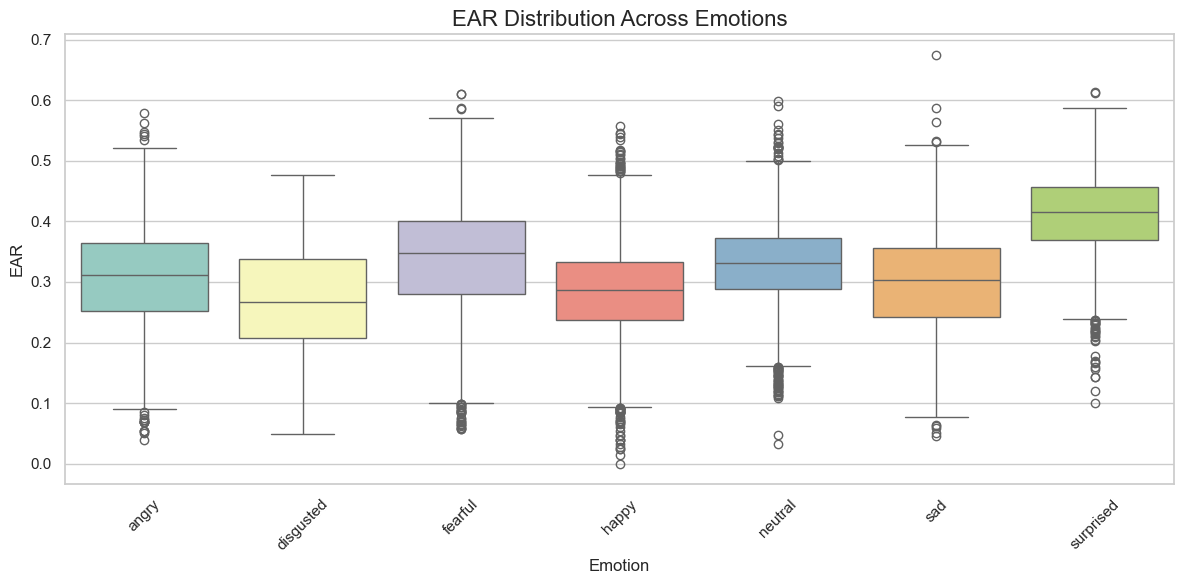

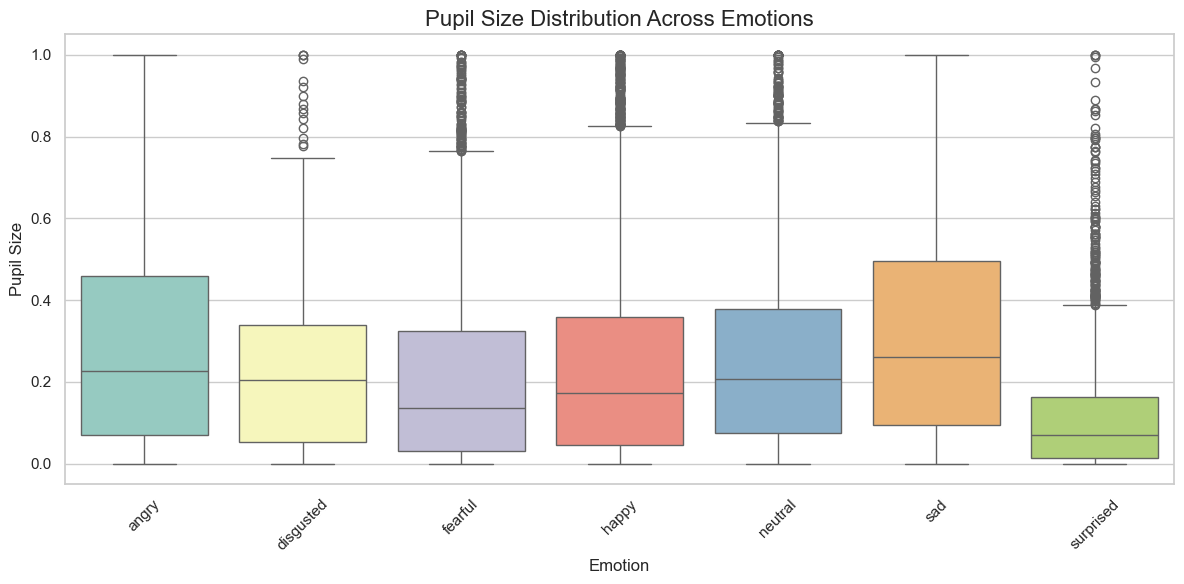

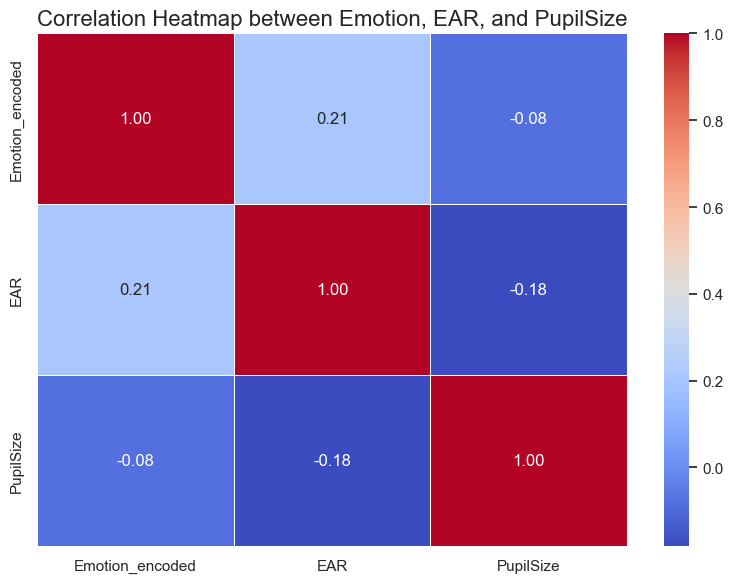

Statistics for each emotion:
                EAR           PupilSize          
               mean       std      mean       std
Emotion                                          
angry      0.306949  0.080768  0.293364  0.261147
disgusted  0.269459  0.092399  0.249394  0.234520
fearful    0.334502  0.094106  0.216376  0.232681
happy      0.284485  0.072918  0.236657  0.232764
neutral    0.329249  0.067034  0.256271  0.226543
sad        0.298346  0.083440  0.320032  0.269346
surprised  0.409974  0.067780  0.120251  0.152904


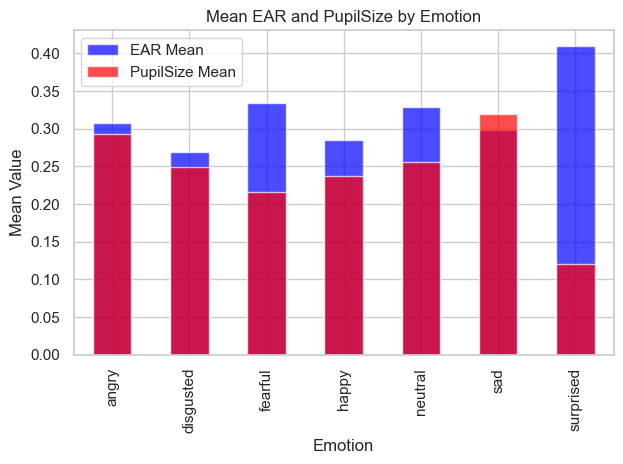

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件
csv_file = "eye_analysis_results_train.csv"
data = pd.read_csv(csv_file)

# 数据检查
print(data.head())  # 查看前几行
print(data.info())  # 检查字段和数据类型

# 计算EAR和PupilSize的Pearson相关系数
correlation = data[["EAR", "PupilSize"]].corr(method="pearson")
print("Pearson correlation between EAR and PupilSize:")
print(correlation)

# 如果要计算情绪与EAR、PupilSize之间的关系，可以通过分组计算每种情绪下的平均EAR和PupilSize
emotion_grouped = data.groupby("Emotion")[["EAR", "PupilSize"]].mean()
print("\nMean EAR and PupilSize for each Emotion:")
print(emotion_grouped)

# 设置图形风格
sns.set(style="whitegrid")

# 1. 分析不同情绪的EAR分布
plt.figure(figsize=(12, 6))
sns.boxplot(x="Emotion", y="EAR", data=data, hue="Emotion", palette="Set3", dodge=False, legend=False)
plt.title("EAR Distribution Across Emotions", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("EAR", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 分析不同情绪的瞳孔大小分布
plt.figure(figsize=(12, 6))
sns.boxplot(x="Emotion", y="PupilSize", data=data, hue="Emotion", palette="Set3", dodge=False, legend=False)
plt.title("Pupil Size Distribution Across Emotions", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Pupil Size", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. EAR 和 PupilSize 的关系（散点图 + 回归线）
# 获取唯一的情绪标签
emotions = data["Emotion"].unique()


# 将情绪标签转换为数值类型（例如，通过Label Encoding）
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Emotion_encoded'] = label_encoder.fit_transform(data['Emotion'])
# 计算相关性矩阵
correlation_matrix = data[["Emotion_encoded", "EAR", "PupilSize"]].corr()
# 使用Seaborn绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap between Emotion, EAR, and PupilSize", fontsize=16)
plt.tight_layout()
plt.show()


# 按情绪分组计算每个情绪的EAR和PupilSize的均值和标准差
emotion_stats = data.groupby("Emotion")[["EAR", "PupilSize"]].agg(["mean", "std"])
print("Statistics for each emotion:")
print(emotion_stats)
# 可以使用柱状图来展示每个情绪下EAR和PupilSize的均值
emotion_stats['EAR', 'mean'].plot(kind='bar', color='blue', alpha=0.7, label='EAR Mean')
emotion_stats['PupilSize', 'mean'].plot(kind='bar', color='red', alpha=0.7, label='PupilSize Mean')
plt.title("Mean EAR and PupilSize by Emotion")
plt.ylabel("Mean Value")
plt.legend()
plt.tight_layout()
plt.show()


我们推测‘EAR’、‘PuilSize’、‘Emotion’存在一定联系

## 对论文的情绪分类器复现
- 来自论文：EmoEyes A Machine Learning Exploration of Emotional States Through Eye Movement Tracking in Visual Content
- 模型网络为
    - 输入层：接收大小为 (48, 48, 1) 的灰度图像。
    - 卷积层 + 批量归一化 + 最大池化 + Dropout：
        - 第1层：64个 (3, 3) 的卷积核，ReLU激活函数，批量归一化，最大池化 (2, 2)，Dropout率为 0.25。
        - 第2层：128个 (3, 3) 的卷积核，ReLU激活函数，批量归一化，最大池化 (2, 2)，Dropout率为 0.25。
    - Flatten层：将特征图展平为一维向量。
    - 全连接层 + 批量归一化 + Dropout：
        - 第1层：128个神经元，ReLU激活函数，批量归一化，Dropout率为 0.25。
        - 第2层：256个神经元，ReLU激活函数，批量归一化，Dropout率为 0.25。
    - 输出层：6个神经元，Softmax激活函数（用于情绪分类）。

In [2]:
# 导包
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 构建分类器
class ImageClassifier():
    def __init__(self, train_data_path, test_data_path, input_size, num_classes):
        # 初始化分类器
        self.train_data_path = train_data_path  # 训练数据路径
        self.test_data_path = test_data_path    # 测试数据路径
        self.input_size = input_size            # 输入图像大小
        self.num_classes = num_classes          # 分类类别数量
    
        # 数据预处理配置
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,            # 数据归一化
            shear_range=0.2,           # 随机剪切变换
            zoom_range=0.2,            # 随机缩放
            horizontal_flip=True       # 随机水平翻转
        )
    
        self.test_datagen = ImageDataGenerator(rescale=1./255)  # 测试数据归一化
    
        # 加载训练数据
        self.train_data_gen = self.train_datagen.flow_from_directory(
            train_data_path,
            target_size=input_size,       # 调整图像大小
            batch_size=128,               # 批处理大小
            class_mode='categorical',     # 多分类模式
            shuffle=True,                 # 数据打乱
            color_mode='grayscale'        # 灰度图模式
        )
    
        # 加载测试数据
        self.test_data_gen = self.test_datagen.flow_from_directory(
            test_data_path,
            target_size=input_size,
            batch_size=128,
            class_mode='categorical',
            shuffle=False,
            color_mode='grayscale'
        )
    
        # 构建CNN模型
        self.model = self._build_model()

    def _build_model(self):
        # 搭建卷积神经网络（CNN）模型
        model = tf.keras.Sequential([
            # 第1个卷积块
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(self.input_size[0], self.input_size[1], 1)),
            tf.keras.layers.BatchNormalization(),    # 批量归一化
            tf.keras.layers.MaxPooling2D((2, 2)),    # 最大池化层
            tf.keras.layers.Dropout(0.25),           # 随机丢弃25%的神经元
    
            # 第2个卷积块
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
    
            # 拉平层
            tf.keras.layers.Flatten(), # 拉平层，将特征图展平成一维
    
            # 全连接层 1
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
    
            # 全连接层 2
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
    
            # 输出层
            tf.keras.layers.Dense(self.num_classes, activation='softmax') # 输出层，使用softmax进行多分类
        ])
    
        # 编译模型
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam优化器
                      loss='categorical_crossentropy',                           # 多分类交叉熵损失
                      metrics=['accuracy'])                                      # 使用准确度作为评价指标
    
        return model


    # def _build_model(self):
    #     # 搭建卷积神经网络（CNN）模型
    #     model = tf.keras.Sequential([
    #         tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.input_size[0], self.input_size[1], 1)),
    #         tf.keras.layers.MaxPooling2D((2, 2)),  # 最大池化层
    #         tf.keras.layers.Dropout(0.2),          # 随机丢弃20%的神经元

    #         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D((2, 2)),
    #         tf.keras.layers.Dropout(0.2),

    #         tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D((2, 2)),
    #         tf.keras.layers.Dropout(0.3),

    #         tf.keras.layers.Flatten(),             # 拉平层，将特征图展平成一维
    #         tf.keras.layers.Dense(128, activation='relu'),   # 全连接层
    #         tf.keras.layers.Dropout(0.5),          # 随机丢弃50%的神经元
    #         tf.keras.layers.Dense(self.num_classes, activation='softmax')  # 输出层，使用softmax进行多分类
    #     ])

    #     # 编译模型
    #     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam优化器
    #                   loss='categorical_crossentropy',                           # 多分类交叉熵损失
    #                   metrics=['accuracy'])                                      # 使用准确度作为评价指标

    #     return model

    def train(self, epochs=50):
        # 训练模型
        history = self.model.fit(
            self.train_data_gen,
            epochs=epochs,
            validation_data=self.test_data_gen,
            verbose=2
        )
        # 保存模型
        self.model.save('trained_model.h5')

        # 显示训练过程中的准确度
        self._plot_training_history(history)

    def evaluate(self):
        # 在测试集上评估模型
        test_loss, test_acc = self.model.evaluate(self.test_data_gen)
        print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        return test_acc

    def predict_multiple(self, imgs):
        # 批量预测
        images = tf.convert_to_tensor(imgs)
        predictions = self.model.predict(images)  # 批量预测
        predicted_classes = np.argmax(predictions, axis=1)  # 获取每个图片的预测标签
        return predicted_classes, predictions

    def _plot_training_history(self, history):
        # 可视化训练过程中的准确度和损失
        plt.figure(figsize=(12, 4))

        # 准确度
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # 损失
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

# 加载测试图片
def load_multiple_images(test_data_path, num_images=10, target_size=(48, 48)):
    # 获取测试数据集目录下的文件夹（每个文件夹代表一个类别）
    class_folders = [folder for folder in os.listdir(test_data_path) if os.path.isdir(os.path.join(test_data_path, folder))]
    
    images = []
    labels = []
    
    # 加载指定数量的图片
    for folder in class_folders:
        folder_path = os.path.join(test_data_path, folder)
        image_files = os.listdir(folder_path)
        
        # 对每个文件夹加载图片，直到达到所需的数量
        for i, image_file in enumerate(image_files):
            if i >= num_images:
                break

            image_path = os.path.join(folder_path, image_file)
            
            # 排除文件夹或其他非图片文件
            if not os.path.isfile(image_path):
                continue  # 如果是文件夹或者无效文件，跳过
            
            try:
                # 加载图片
                img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')
                
                # 将图片转换为数组
                img_array = image.img_to_array(img)
                
                # 归一化处理
                img_array = img_array / 255.0
                
                images.append(img_array)
                labels.append(folder)  # 文件夹名称作为标签
                
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                
            if len(images) >= num_images:
                break
                
        if len(images) >= num_images:
            break
    
    # 将图片列表转换为 numpy 数组，形状为 (num_images, 48, 48, 1)
    images = np.array(images)
    
    return images, labels


对分类器进行训练与评估

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


C:\Users\34341\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\34341\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
225/225 - 98s - 435ms/step - accuracy: 0.2263 - loss: 2.2948 - val_accuracy: 0.2476 - val_loss: 2.2521
Epoch 2/50
225/225 - 98s - 433ms/step - accuracy: 0.2861 - loss: 2.0165 - val_accuracy: 0.2705 - val_loss: 4.1026
Epoch 3/50
225/225 - 96s - 429ms/step - accuracy: 0.3203 - loss: 1.8954 - val_accuracy: 0.3671 - val_loss: 1.6557
Epoch 4/50
225/225 - 95s - 421ms/step - accuracy: 0.3465 - loss: 1.8054 - val_accuracy: 0.4062 - val_loss: 1.5501
Epoch 5/50
225/225 - 96s - 429ms/step - accuracy: 0.3603 - loss: 1.7401 - val_accuracy: 0.4245 - val_loss: 1.5088
Epoch 6/50
225/225 - 96s - 426ms/step - accuracy: 0.3800 - loss: 1.6872 - val_accuracy: 0.4333 - val_loss: 1.4936
Epoch 7/50
225/225 - 94s - 417ms/step - accuracy: 0.3958 - loss: 1.6275 - val_accuracy: 0.4582 - val_loss: 1.4236
Epoch 8/50
225/225 - 92s - 410ms/step - accuracy: 0.4083 - loss: 1.5814 - val_accuracy: 0.4521 - val_loss: 1.4356
Epoch 9/50
225/225 - 93s - 411ms/step - accuracy: 0.4172 - loss: 1.5450 - val_accuracy: 

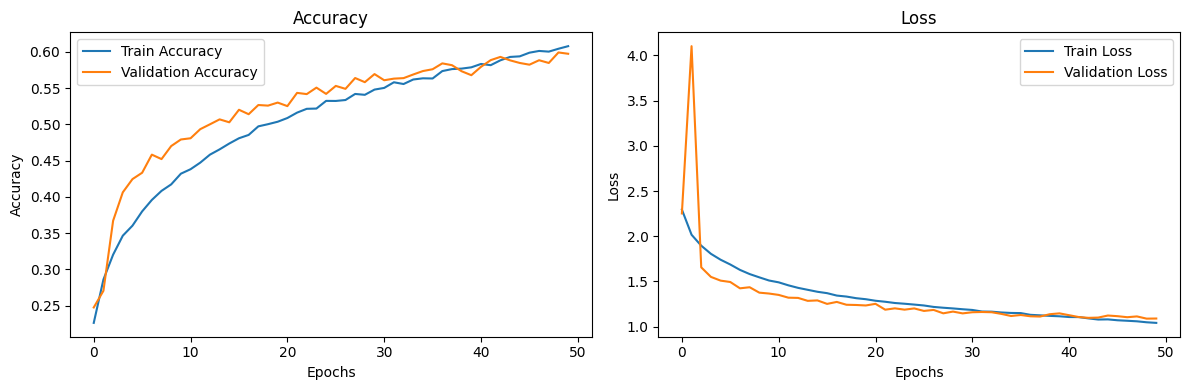

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5520 - loss: 1.1816
Test Loss: 1.089512586593628, Test Accuracy: 0.5972415804862976
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step
Confusion Matrix:
 [[ 513    4   68   80  133  125   35]
 [  40   43    3    5    6   10    4]
 [ 152    5  328   80  129  199  131]
 [  74    0   34 1473   88   58   47]
 [  92    1   59  150  744  154   33]
 [ 193    3  110  120  249  534   38]
 [  27    1   51   42   35   23  652]]


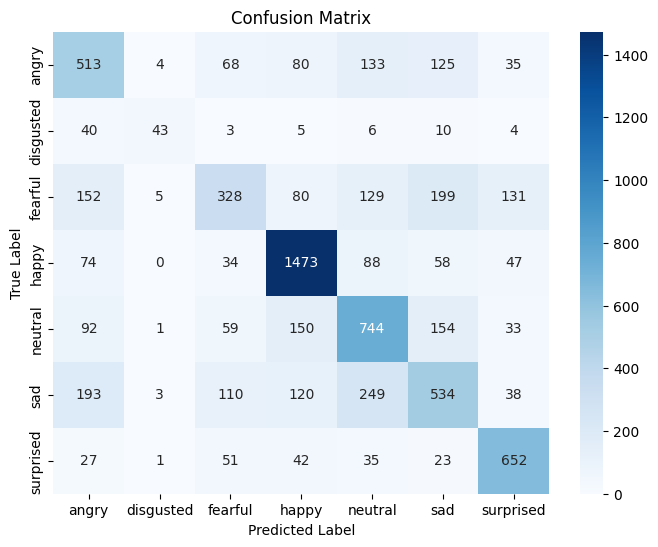

Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.54      0.50       958
   disgusted       0.75      0.39      0.51       111
     fearful       0.50      0.32      0.39      1024
       happy       0.76      0.83      0.79      1774
     neutral       0.54      0.60      0.57      1233
         sad       0.48      0.43      0.45      1247
   surprised       0.69      0.78      0.74       831

    accuracy                           0.60      7178
   macro avg       0.60      0.56      0.56      7178
weighted avg       0.59      0.60      0.59      7178

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,410,839 (28.27 MB)

 Trainable params: 2,469,895 (9.42 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 4,939,792 (18.84 MB)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_metrics(classifier, test_data_gen):
    # 获取真实标签和预测结果
    y_true = test_data_gen.classes
    y_pred_prob = classifier.model.predict(test_data_gen)  # 获取预测概率
    y_pred = np.argmax(y_pred_prob, axis=1)                # 转换为预测类别

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data_gen.class_indices.keys(), yticklabels=test_data_gen.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 计算分类报告
    report = classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys())
    print("Classification Report:\n", report)

train_data_path = 'archive/train'
test_data_path = 'archive/test'
input_size = [48, 48]
num_classes = 7
# 初始化分类器
classifier = ImageClassifier(train_data_path, test_data_path, input_size, num_classes)

# 训练模型
classifier.train(epochs=50)

# 评估模型
classifier.evaluate()
# 获取分类准确率、F1-Score 和混淆矩阵
evaluate_metrics(classifier, classifier.test_data_gen)
# 打印模型框架
print("Model Summary:")
classifier.model.summary()

对分类器进行预测检验

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


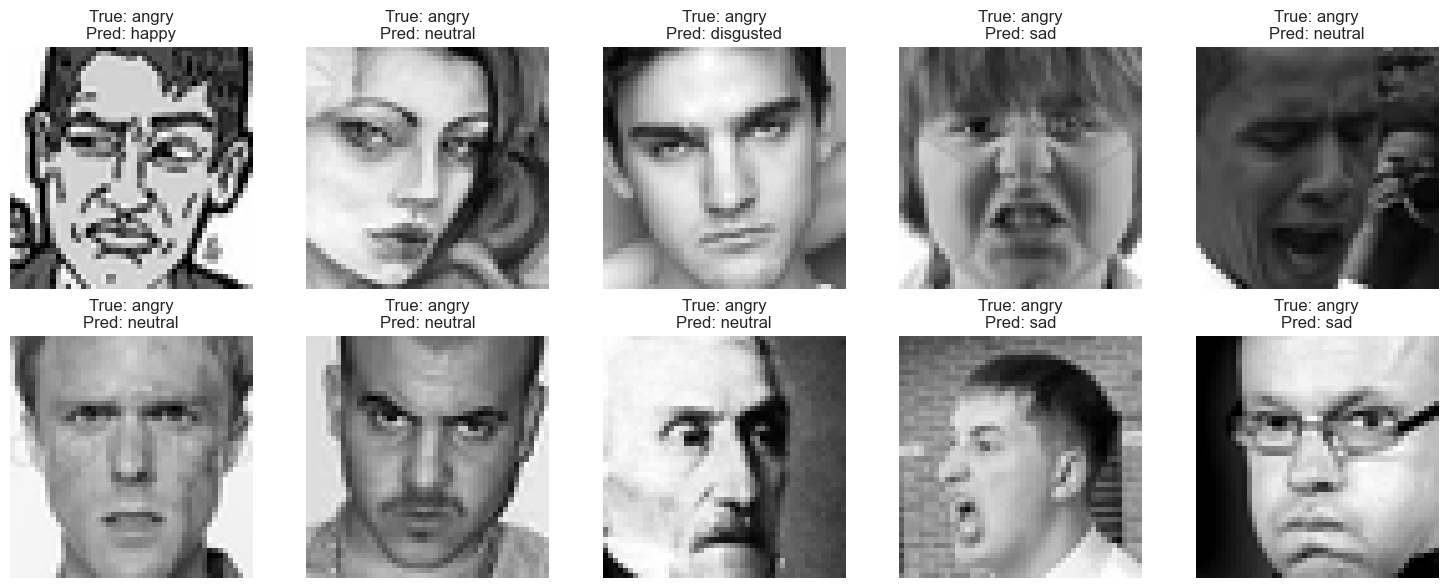

In [28]:
import matplotlib.pyplot as plt

def visualize_predictions(imgs, true_labels, predicted_classes, class_names, num_images=10):
    # 创建一个图形，指定每行显示 5 张图片
    num_cols = 5
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)  # 计算需要的行数
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    
    # 将 axes 调整为 1D 列表，方便循环
    axes = axes.flatten()
    
    # 遍历所有图片并在对应的子图中显示
    for i in range(num_images):
        ax = axes[i]  # 获取当前子图
        ax.imshow(imgs[i], cmap='gray')  # 显示图片
        ax.set_title(f"True: {true_labels[i]}\nPred: {class_names[predicted_classes[i]]}")  # 设置标题
        ax.axis('off')  # 关闭坐标轴
    
    # 如果图形中有多余的子图（例如图片少于 5 的倍数），将它们隐藏
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # 显示图形
    plt.tight_layout()
    plt.show()

# 加载 10 张图片进行预测
imgs, true_labels = load_multiple_images(test_data_path, num_images=10)

# 进行批量预测
predicted_classes, predictions = classifier.predict_multiple(imgs)

# 获取分类标签
class_names = list(classifier.train_data_gen.class_indices.keys())

# 可视化 10 张图片
visualize_predictions(imgs, true_labels, predicted_classes, class_names, num_images=10)

## 改进分类器
- 改进思路：通过融合特征
- 融合特征“EAR”、“PuilSize”

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ImageClassifier():
    def __init__(self, image_train, train_features, train_labels, image_test, test_features, test_labels, input_size, num_classes):
        # 初始化分类器
        self.image_train = image_train  # 训练图片路径
        self.train_features = train_features  # 训练额外特征
        self.train_labels = train_labels  # 训练标签
        self.image_test = image_test  # 测试图片路径
        self.test_features = test_features  # 测试额外特征
        self.test_labels = test_labels  # 测试标签
        self.input_size = input_size  # 输入图像大小
        self.num_classes = num_classes  # 分类类别数量
    
        # 数据预处理配置
        self.train_datagen = ImageDataGenerator(rescale=1./255)  # 数据归一化
        self.test_datagen = ImageDataGenerator(rescale=1./255)  # 测试数据归一化
    
        # 加载训练数据
        self.train_data = self._load_data(image_train, train_features, train_labels)
        self.test_data = self._load_data(image_test, test_features, test_labels)

        # 构建CNN模型
        self.model = self._build_model()

    def _load_data(self, image_paths, features, labels):
        images = []
        for img_path in image_paths:
            img = image.load_img(img_path, target_size=self.input_size)
            img = image.img_to_array(img) / 255.0  # 归一化图像
            images.append(img)
        
        images = np.array(images)
        features = np.array(features)
        labels = np.array(labels)
        
        return (images, features, labels)

    def _build_model(self):
        # 搭建卷积神经网络（CNN）模型
        input_image = tf.keras.layers.Input(shape=(self.input_size[0], self.input_size[1], 3))  # 输入图像
        input_features = tf.keras.layers.Input(shape=(self.train_features.shape[1],))  # 输入额外特征

        # 卷积神经网络部分
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

        x = tf.keras.layers.Flatten()(x)

        # 将图像特征和额外特征合并
        x = tf.keras.layers.Concatenate()([x, input_features])

        # 全连接层
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.25)(x)

        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.25)(x)

        output = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        # 构建最终的模型
        model = tf.keras.models.Model(inputs=[input_image, input_features], outputs=output)

        # 编译模型
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

    def train(self, epochs=50, batch_size=128):
        # 训练模型
        history = self.model.fit(
            [self.train_data[0], self.train_data[1]],  # 图像和额外特征
            self.train_data[2],  # 标签
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([self.test_data[0], self.test_data[1]], self.test_data[2]),  # 测试数据
            verbose=2
        )
        # 保存模型
        self.model.save('trained_model_better.h5')

        # 显示训练过程中的准确度
        self._plot_training_history(history)

    def evaluate(self):
        # 在测试集上评估模型
        test_loss, test_acc = self.model.evaluate([self.test_data[0], self.test_data[1]], self.test_data[2])
        print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        return test_acc
    
    def _plot_training_history(self, history):
        # 可视化训练过程中的准确度和损失
        plt.figure(figsize=(12, 4))

        # 准确度
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # 损失
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

从CSV文件提取数据并进行标准化

In [3]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder

def load_features(dataframe, num_classes):
    # 提取EAR和PupilSize特征
    features = dataframe[['EAR', 'PupilSize']].values

    # 对特征进行归一化
    features = (features - features.mean(axis=0)) / features.std(axis=0)

    # 提取标签
    labels = dataframe['Emotion'].values

    Images = dataframe['Image'].values

    # 使用LabelEncoder将字符串标签转换为整数
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)  # 转换为整数标签

    # 将标签转换为one-hot编码
    labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

    # 返回特征、标签及标签映射
    return Images, features, labels_one_hot, dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

csv_path_train = 'eye_analysis_results_train.csv'
csv_path_test = 'eye_analysis_results_test.csv'
dataframe_train = pd.read_csv(csv_path_train)
dataframe_test = pd.read_csv(csv_path_test)

image_train, train_features, train_labels, train_label_mapping = load_features(dataframe_train, num_classes=7)
image_test, test_features, test_labels, test_label_mapping = load_features(dataframe_test, num_classes=7)

print(train_label_mapping)

{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


训练改进的模型并评估

Epoch 1/50


C:\Users\34341\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


157/157 - 67s - 425ms/step - accuracy: 0.2564 - loss: 2.2342 - val_accuracy: 0.1337 - val_loss: 2.5144
Epoch 2/50
157/157 - 64s - 410ms/step - accuracy: 0.3546 - loss: 1.8863 - val_accuracy: 0.0382 - val_loss: 5.1995
Epoch 3/50
157/157 - 64s - 408ms/step - accuracy: 0.3922 - loss: 1.7385 - val_accuracy: 0.2031 - val_loss: 3.8183
Epoch 4/50
157/157 - 63s - 400ms/step - accuracy: 0.4273 - loss: 1.6426 - val_accuracy: 0.4216 - val_loss: 1.7085
Epoch 5/50
157/157 - 64s - 407ms/step - accuracy: 0.4451 - loss: 1.5733 - val_accuracy: 0.4714 - val_loss: 1.4497
Epoch 6/50
157/157 - 62s - 394ms/step - accuracy: 0.4685 - loss: 1.4838 - val_accuracy: 0.4864 - val_loss: 1.4021
Epoch 7/50
157/157 - 62s - 393ms/step - accuracy: 0.4841 - loss: 1.4370 - val_accuracy: 0.5062 - val_loss: 1.3326
Epoch 8/50
157/157 - 63s - 403ms/step - accuracy: 0.4999 - loss: 1.3826 - val_accuracy: 0.5128 - val_loss: 1.3182
Epoch 9/50
157/157 - 63s - 401ms/step - accuracy: 0.5124 - loss: 1.3332 - val_accuracy: 0.5194 - va

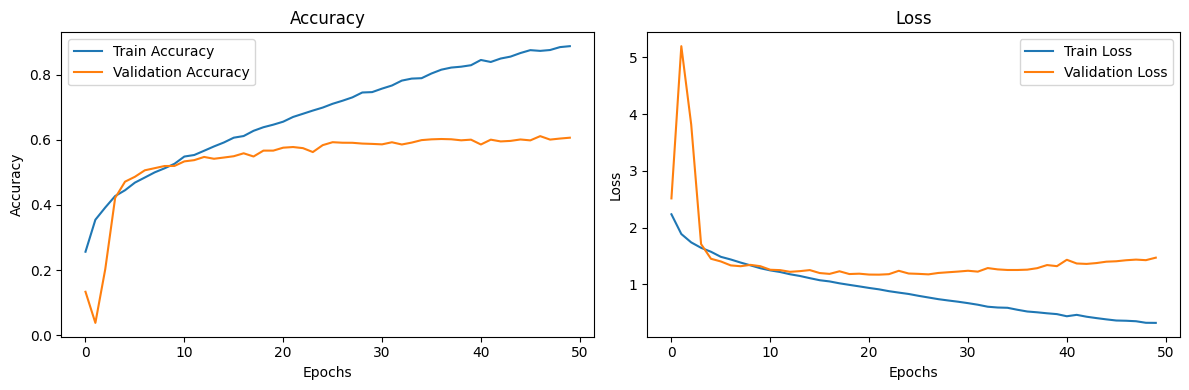

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5540 - loss: 1.6554
Test Loss: 1.4690030813217163, Test Accuracy: 0.6062424778938293
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Accuracy: 0.61
F1-score: 0.60
Confusion Matrix:
[[ 287    0   60   80   99  100   19]
 [  19   46    3    5    5    5    0]
 [  83    0  246   63   92  104   50]
 [  40    2   23 1198   90   53   19]
 [  70    1   44  118  578  130    8]
 [  79    6   61   83  184  273    6]
 [  23    3   44   49   28   17  402]]


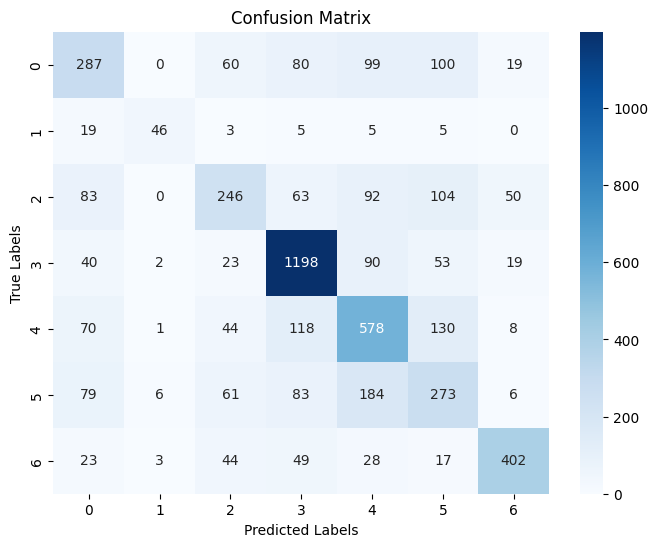

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18432)     │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18434)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,359,680 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     33,024 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,415,063 (28.29 MB)

 Trainable params: 2,471,303 (9.43 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 4,942,608 (18.85 MB)

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

input_size = (48, 48)
num_classes = 7

# 初始化分类器并训练模型
classifier = ImageClassifier(image_train, train_features, train_labels, image_test, test_features, test_labels, input_size, num_classes)
classifier.train(epochs=50)
classifier.evaluate()

# 预测测试集结果
y_pred_probs = classifier.model.predict([classifier.test_data[0], classifier.test_data[1]])  # 概率输出
y_pred = np.argmax(y_pred_probs, axis=1)  # 转化为类别索引
y_true = np.argmax(classifier.test_data[2], axis=1)  # 转化为真实标签索引

# 计算分类准确率
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 计算F1-score
f1 = f1_score(y_true, y_pred, average='weighted')  # 加权平均
print(f"F1-score: {f1:.2f}")

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

classifier.model.summary()

使用改进的模型预测

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


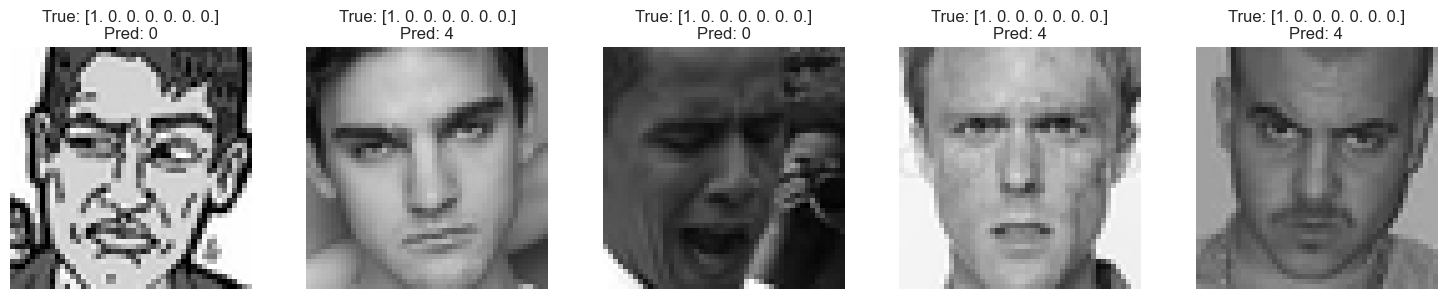

In [69]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize(model, image_test, test_features, test_labels, indices, target_size=(48, 48), num_images_per_row=5):
    # 获取选择的图像、特征和标签
    selected_image_paths = [image_test[i] for i in indices]
    selected_features = test_features[indices]
    selected_labels = test_labels[indices]

    # 加载并预处理选中的图像
    selected_images = []
    for img_path in selected_image_paths:
        # 加载图像并调整大小
        img = image.load_img(img_path, target_size=target_size)
        # 转换为 numpy 数组并归一化
        img_array = image.img_to_array(img) / 255.0  # 归一化到 [0, 1]
        selected_images.append(img_array)

    # 将列表转换为 numpy 数组
    selected_images = np.array(selected_images)

    # 进行预测
    predictions = model.predict([selected_images, selected_features])

    # 获取预测的标签
    predicted_labels = np.argmax(predictions, axis=1)

    # 计算需要的行数
    num_images = len(indices)
    num_rows = (num_images // num_images_per_row) + (1 if num_images % num_images_per_row != 0 else 0)

    # 创建子图
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 3 * num_rows))
    axes = axes.flatten()  # 展平 axes 数组，方便索引

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(selected_images[i])
        ax.set_title(f"True: {selected_labels[i]}\nPred: {predicted_labels[i]}")
        ax.axis('off')  # 不显示坐标轴

    # 如果有空余的子图位置，将其去除
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 你选择了5张图像进行预测
indices = [0, 1, 2, 3, 4]

# 调用预测并可视化
predict_and_visualize(model, image_test, test_features, test_labels, indices, num_images_per_row=5)